# Donchian Breakout

In [1]:
import pandas as pd
import numpy as np
import scipy
import pandas_ta as ta
import matplotlib.pyplot as plt

## donchian.py

In [4]:
def donchian_breakout(df: pd.DataFrame, lookback: int):
    # input df is assumed to have a 'close' column
    df['upper'] = df['close'].rolling(lookback - 1).max().shift(1)
    df['lower'] = df['close'].rolling(lookback - 1).min().shift(1)
    df['signal'] = np.nan
    df.loc[df['close'] > df['upper'], 'signal'] = 1
    df.loc[df['close'] < df['lower'], 'signal'] = -1
    df['signal'] = df['signal'].ffill()

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['return'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['return'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    
    long_trades['type'] = 1
    short_trades['type'] = -1
    all_trades = pd.concat([long_trades, short_trades])
    all_trades = all_trades.sort_index()
    
    return long_trades, short_trades, all_trades


In [13]:
# data = pd.read_csv('BTCUSDT3600.csv')
data = pd.read_csv('../datasets/btc_1h.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

data['r'] = np.log(data['close']).diff().shift(-1)
donchian_breakout(data, 24)
printData = data[['close', 'upper', 'lower', 'signal', 'r']]
print(printData[50:100])
# print(printData[-50:])

long_trades, short_trades, all_trades = get_trades_from_signal(data, data['signal']) 
print(len(long_trades), len(short_trades))
# print(long_trades[:50])

                       close    upper    lower  signal         r
date                                                            
2017-08-19 06:00:00  3986.87  4356.31  3975.69    -1.0  0.011621
2017-08-19 07:00:00  4033.47  4356.31  3975.69    -1.0 -0.008583
2017-08-19 08:00:00  3999.00  4356.31  3975.69    -1.0  0.017156
2017-08-19 09:00:00  4068.20  4356.31  3975.69    -1.0 -0.016761
2017-08-19 10:00:00  4000.58  4340.31  3975.69    -1.0 -0.010802
2017-08-19 11:00:00  3957.60  4331.71  3975.69    -1.0  0.034129
2017-08-19 12:00:00  4095.00  4293.09  3957.60    -1.0 -0.013562
2017-08-19 13:00:00  4039.84  4259.40  3957.60    -1.0  0.000636
2017-08-19 14:00:00  4042.41  4250.34  3957.60    -1.0 -0.017559
2017-08-19 15:00:00  3972.05  4250.34  3957.60    -1.0  0.007012
2017-08-19 16:00:00  4000.00  4193.35  3957.60    -1.0  0.006819
2017-08-19 17:00:00  4027.37  4163.49  3957.60    -1.0  0.014524
2017-08-19 18:00:00  4086.29  4163.49  3957.60    -1.0 -0.002492
2017-08-19 19:00:00  4076

Profit Factor 1.0194855331263422
Avg Trade 0.0018092921860783792
Win Rate 0.3238993710691824


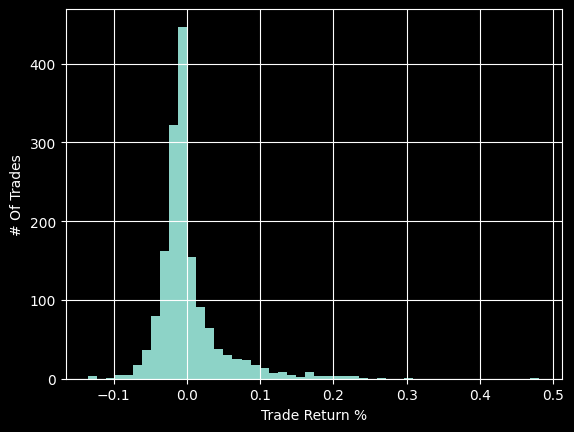

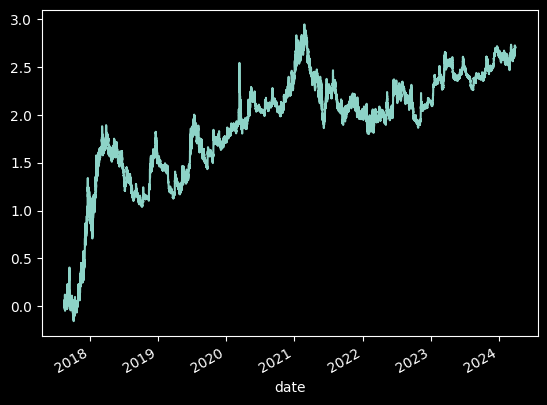

<Axes: xlabel='lag1', ylabel='return'>

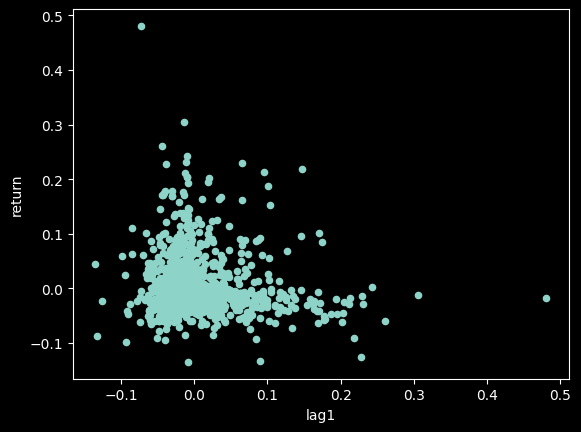

In [19]:
# data = pd.read_csv('BTCUSDT3600.csv')
data = pd.read_csv('../datasets/btc_1h.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()


data['r'] = np.log(data['close']).diff().shift(-1)
# donchian_breakout(data, 72)
donchian_breakout(data, 24)
# print(data[:50])
plt.style.use('dark_background')

'''
data['close'].plot()
data['upper'].plot(color='green')
data['lower'].plot(color='red')
plt.twinx()
data['signal'].plot(color='orange')
plt.show()
'''
rets = data['r'] * data['signal']
pf = rets[rets>0].sum() / rets[rets<0].abs().sum()
print("Profit Factor", pf)
print("Avg Trade", all_trades['return'].mean())
print("Win Rate", len(all_trades[all_trades['return'] > 0]) / len(all_trades))

long_trades, short_trades, all_trades = get_trades_from_signal(data, data['signal']) 
all_trades['return'].hist(bins=50)
plt.xlabel("Trade Return %")
plt.ylabel("# Of Trades")
plt.show()


(data['r'] * data['signal']).cumsum().plot()
plt.show()

all_trades['lag1'] = all_trades['return'].shift(1)
all_trades.plot.scatter('lag1', 'return')


## last_trade_signal.py

Original PF 1.0194855331263422
Last Lose PF 1.0440104443686387
Last Win PF 0.9728253688154566


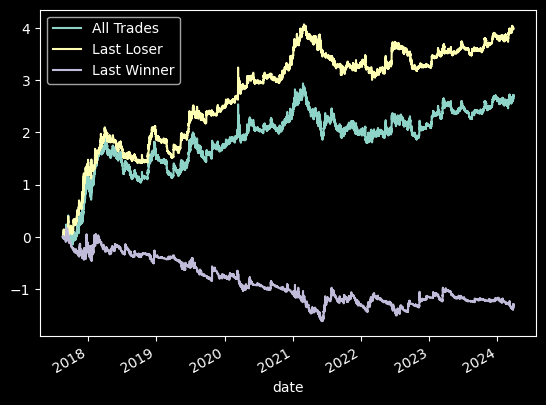

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


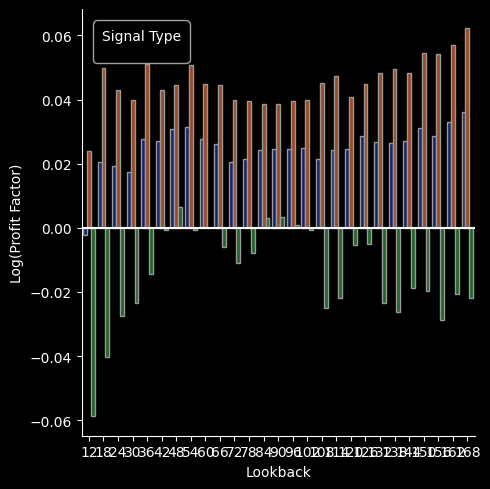

In [10]:
import pandas as pd
import numpy as np
import scipy
import pandas_ta as ta
from donchian import donchian_breakout, get_trades_from_signal
import matplotlib.pyplot as plt


def last_trade_adj_signal(ohlc: pd.DataFrame, signal: np.array, last_winner: bool = False):
    # Input signal must be long and short, only having values of 1 and -1.
    # Adjust a signal to only trade if last trade was a winner/loser

    last_type = -1
    if last_winner:
        last_type = 1
    
    close = ohlc['close'].to_numpy()
    mod_signal = np.zeros(len(signal))

    long_entry_p = np.nan
    short_entry_p = np.nan
    last_long = np.nan
    last_short = np.nan

    last_sig = 0.0
    for i in range(len(close)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            long_entry_p = close[i]
            if not np.isnan(short_entry_p):
                last_short = np.sign(short_entry_p - close[i])
                short_entry_p = np.nan

        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            short_entry_p = close[i]
            if not np.isnan(long_entry_p):
                last_long = np.sign(close[i] - long_entry_p)
                long_entry_p = np.nan
        
        last_sig = signal[i]
        
        if signal[i] == 1.0 and last_short == last_type:
            mod_signal[i] = 1.0
        if signal[i] == -1.0 and last_long == last_type:
            mod_signal[i] = -1.0
        
    return mod_signal



if __name__ == '__main__':


    # data = pd.read_csv('BTCUSDT3600.csv')
    data = pd.read_csv('../datasets/btc_1h.csv')
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')
    data = data.dropna()

    
    data['r'] = np.log(data['close']).diff().shift(-1)
    donchian_breakout(data, 24)
    data['last_lose'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=False)
    data['last_win'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=True)
   
    orig = data['r'] * data['signal']
    lose = data['r'] * data['last_lose']
    win = data['r'] * data['last_win']
    print("Original PF", orig[orig > 0].sum() / orig[orig < 0].abs().sum())
    print("Last Lose PF", lose[lose > 0].sum() / lose[lose < 0].abs().sum())
    print("Last Win PF", win[win > 0].sum() / win[win < 0].abs().sum())

    plt.style.use('dark_background')
    orig.cumsum().plot(label='All Trades')
    lose.cumsum().plot(label='Last Loser')
    win.cumsum().plot(label='Last Winner')
    plt.legend()
    plt.show()


    # Compute across many lookbacks
    lookbacks = list(range(12, 169, 6))
    pfs = []
    types = []
    lbs = []
    for lookback in lookbacks:
        donchian_breakout(data, lookback)
        data['last_lose'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=False)
        data['last_win'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=True)
        
        orig = data['r'] * data['signal']
        lose = data['r'] * data['last_lose']
        win = data['r'] * data['last_win']

        pfs.append ( np.log( orig[orig > 0].sum() / orig[orig < 0].abs().sum() ) )
        lbs.append(lookback)
        types.append("All")
        
        pfs.append (np.log( lose[lose > 0].sum() / lose[lose < 0].abs().sum() ) )
        lbs.append(lookback)
        types.append("Last Loser")
        
        pfs.append ( np.log( win[win > 0].sum() / win[win < 0].abs().sum() ) )
        lbs.append(lookback)
        types.append("Last Winner")
    

    import seaborn as sns 
    df = pd.DataFrame()
    df['Lookback'] = lbs
    df['Type'] = types
    df['Log(Profit Factor)'] = pfs
    
    plt.style.use('dark_background')
    sns.catplot(
        data=df, y="Log(Profit Factor)", x='Lookback', hue="Type", kind='bar',
        palette="dark", edgecolor=".6", legend=False
    )
    plt.axhline(0.0, color='white')
    plt.legend(prop={'size': 16}, title='Signal Type')
    plt.show()


## runs_indicator.py

In [11]:
import pandas as pd
import numpy as np
import scipy
import pandas_ta as ta
from runs_test import runs_test
import matplotlib.pyplot as plt

# Didnt include in video, but I've seen talk online about
# using the runs test as an indicator
# Here I compute the runs test z-score using the signs of returns
# in a rolling window. I have not researched this much, idk if its any good.
# But its a well normalized indicator for yoru collection, have fun.  

def runs_trend_indicator(close: pd.Series, lookback: int):
    change_sign = np.sign(close.diff()).to_numpy()
    ind = np.zeros(len(close))
    ind[:] = np.nan

    for i in range(lookback, len(close)):
        ind[i] = runs_test(change_sign[i - lookback + 1: i+1])

    return ind

if __name__ == '__main__':
    

    # data = pd.read_csv('BTCUSDT3600.csv')
    data = pd.read_csv('../datasets/btc_1h.csv')
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')
    data = data.dropna()

    data['runs_ind'] = runs_trend_indicator(data['close'], 24)


## runs_test.py

Donchian Breakout 24 Z-Score: 3.1858691173750997


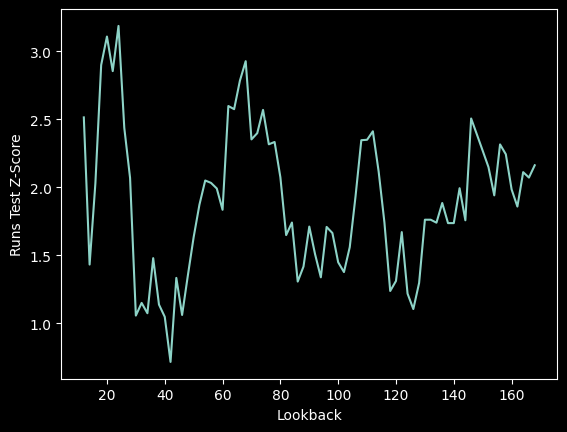

In [12]:
def runs_test(signs: np.array):
    # signs must consist of only 1 and -1
    # Returns Z-Score of observed runs 
    assert len(signs) >= 2
    
    n_pos = len(signs[signs > 0])
    n_neg = len(signs[signs < 0])
    n = len(signs)
    
    # Mean number of expected runs
    mean = 2 * n_pos * n_neg / n  + 1
    # Stadard of expected runs
    std = (mean - 1) * (mean - 2) / ( n - 1 ) # Variance
    std = std ** 0.5

    #print(mean)
    #print(std**2)
    #print(std)
   
    # Count observed runs
    runs = 1
    for i in range(1, len(signs)):
        if signs[i] != signs[i-1]:
            runs += 1 # Streak broken
    #print(runs)
    # Z-Score
    z = (runs - mean) / std
    return z


if __name__ == '__main__':


    # data = pd.read_csv('BTCUSDT3600.csv')
    data = pd.read_csv('../datasets/btc_1h.csv')
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')
    data = data.dropna()
    
    donchian_breakout(data, 24)
    _,_,all_trades = get_trades_from_signal(data, data['signal'])
    signs = np.sign(all_trades['return']).to_numpy()
    runs_z = runs_test(signs)
    # For 24 we get 2.7...
    print("Donchian Breakout 24 Z-Score:", runs_z)

    all_runs_z = []
    lookbacks = list(range(12, 169, 2))
    for lookback in lookbacks:
        donchian_breakout(data, lookback)
        _,_,all_trades = get_trades_from_signal(data, data['signal'])
        signs = np.sign(all_trades['return']).to_numpy()
        runs_z = runs_test(signs)

        all_runs_z.append(runs_z)
    
    plt.style.use('dark_background')
    pd.Series(all_runs_z, index=lookbacks).plot()
    plt.xlabel("Lookback")
    plt.ylabel("Runs Test Z-Score")
    plt.show()
